<a href="https://colab.research.google.com/github/erichardson97/cell_crushers/blob/main/modelling/modelling_functions_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [263]:
from google.colab import drive, files
import pandas as pd
from typing import Union, Callable
import numpy as np
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import pylab
import scipy.stats as stats
import os
import sklearn
%pip install striprtf
from striprtf.striprtf import rtf_to_text

drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/CMIPB_Files')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# @title Read in file and specify target feature.
data = pd.read_csv('/content/drive/MyDrive/CMIPB_Files/IntegratedData.tsv', sep = '\t', index_col = 0)
target = 'Day14_IgG_Titre'
data = data.rename(columns = {target: 'Target'})
data = data[data['Target']!='ND']
data['Target'] = data['Target'].map(float)

<ipython-input-3-bd3383201d12>:2: DtypeWarning: Columns (23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,

In [61]:

class Dataset():
  """
  Dataset class which accepts pd dataframe.
  Filter to subjects for which all have a value.
  Z-scale.
  """
  def __init__(self, data: pd.DataFrame, target: str = 'Target'):
    self.data = data
    self.demographic_features = ['Titre_IgG_PT', 'age', 'biological_sex', 'infancy_vac', 'dataset']
  def filter(self, feature_list: list = []):
    '''
    Pass a feature list and will filter to the subset of rows which have a value
    for this feature
    '''
    if feature_list != []:
      self.feature_list = list(set(feature_list).union(set(self.demographic_features))) + ['Target']
    else:
      self.feature_list = self.data.columns
    self.data_filtered = self.data[~(self.data[self.feature_list].applymap(lambda x:x=='ND')!=False).any(1)][self.feature_list]
  def make_float(self, feature_list: list = []):
    '''
    Pass a feature list and will filter to the subset of rows which have a value
    for this feature
    '''
    for feat in feature_list:
      print(self.data_filtered[feat])
      self.data_filtered[feat] = self.data_filtered[feat].map(float)
  def normalize(self, features_to_normalize: list):
    '''
    Pass a list of continuous features for use by StandardScaler
    '''
    self.data_normalized = self.data_filtered.copy()
    self.data_normalized[features_to_normalize] = StandardScaler().fit_transform(self.data_filtered[features_to_normalize])

# ds = Dataset(data)
# ds.filter([])
# ds.normalize(list(set(ds.feature_list).difference(set(['biological_sex','infancy_vac','dataset']))))


In [4]:
# @title Functions for reading.

def read_sheet_url(url: str) -> pd.DataFrame:
  return pd.read_csv(url.replace('/edit#gid=', '/export?format=csv&gid='))

def read_rtf(file: str) -> set:
  with open(file.replace('rtf','tsv'), 'w') as k:
    k.write('\n'.join(rtf_to_text(open(file,'r').read()).split('UniProtKB'))[1:])
  genes = set(pd.read_csv(file.replace('rtf','tsv'), sep = '\t')['Gene'].unique())
  return genes

def read_rtf2(file: str) -> set:
  gene1 = rtf_to_text(open(file, 'r').read()).split('GO:')[0].split('\t')[-2]
  names = [p.split('\t')[-2] for p in rtf_to_text(open(file, 'r').read()).split('GO:')[1:]]
  names = [p.replace('UniProt','').replace('GO_Central','').replace('ComplexPortal','').replace('BHF-UCL', '').replace('Ensembl', '') for p in names]
  return set(names).union(set([gene1]))

In [7]:
sciimm_features = list(pd.read_excel('EVE_HIPCTeam_SciImm_2017.xlsx')['Gene'])#list(set(['GEX_'+p for p in ]).intersection(set(data.columns)))
julie_features = list(set(['LONP2', 'PAPSS2', 'EPHB1','ADAM12','SMC1A','RETN','CD101']))

bcellactivation = 'https://docs.google.com/spreadsheets/d/1WCi_VIJLipzaPQl6W2wK_yXzyzcBxLWd/edit#gid=1986511717'
bcelldifferentiation = 'https://docs.google.com/spreadsheets/d/1LkWdSaiakDqbJVRIDCUJiXAZOEV6fHUE/edit#gid=1705069152'
isotypeswitching = 'https://docs.google.com/spreadsheets/d/1GFmXIBYfTWccsKMW8OwEDyl6yynd0Mx1/edit#gid=1931371240'
bcellproliferation = 'https://docs.google.com/spreadsheets/d/1EgU8i_h-jvjEQ0Cx8tR6jx2h20P7U0_c/edit#gid=186885105'
go_sheets = {'Activation':read_sheet_url(bcellactivation)['Gene'].unique(),
             'Differentiation':read_sheet_url(bcelldifferentiation)['Gene'].unique(),
             'Isotype switching':read_sheet_url(isotypeswitching)['Gene'].unique(),
             'B-cell proliferation':read_sheet_url(bcellproliferation)['Gene'].unique()}
go_sheets['Plasma cell genes'] = set(['BCL6','CR1','C3BR','IL10','IL2','ITM2A','LGALS1','NFKBIZ','NKX2-3','XBP1'])
go_sheets['B cell activation'] = read_rtf('b_cell_activation.rtf')
go_sheets['IgG'] = read_rtf2('IgG_genes.rtf')
go_sheets['Literature_features'] = sciimm_features+julie_features
all_genes = set().union(*[set(go_sheets[p]) for p in go_sheets])
all_genes = set(['GEX_'+p for p in all_genes])
in_dataset = all_genes.intersection(ds.data.columns)
in_dataset_df = {}
for k in in_dataset:
  in_dataset_df[k] = {}
  for p in go_sheets:
    if k.split('_')[1] in go_sheets[p]:
      in_dataset_df[k][p] = 1
in_dataset_df = pd.DataFrame(in_dataset_df).fillna(0).T

In [145]:
class HyperparamSearch():
  def __init__(self):
      ''

  def run_search(self, params: dict, cv_func: Callable, cv_args: dict):
      parameter_indices = {}
      cv_results_total = []
      for f, g in enumerate(ParameterGrid(params)):
          parameter_indices[f] = g
          cv_args['model_params'] = g
          cv_results = cv_func(**cv_args)
          cv_results_total.append(cv_results)
      return cv_results_total, parameter_indices


In [269]:
# @title CV Functions.

def corr_coeff_report(y_pred: list, y_true: list) -> float:
  '''
  Function that returns Spearman's correlation coefficient between predictions
  and true target values.
  In contrast to corr_coeff, this is not a loss function.
  '''
  return spearmanr(y_pred, y_true)[0]

def corr_coeff(y_pred: list, y_true: list) -> float:
    '''
    Function that turns Spearman's correlation coefficient between predictions
    and true target values, into a loss (i.e. the smaller the coefficient/if coefficient is negative,
    the larger the loss).
    In contrast to corr_coeff_report, this IS to be used as a loss function (NB
    non-differentiable).
    '''
    return float(1 - spearmanr(y_pred, y_true)[0])

def loocv(data: pd.DataFrame, features: list, target: str, model_class):
  '''
  Function for Leave-one out cross-validation.
  Score is MSE, because there is only one sample.
  So cannot calculate a correlation coefficient.
  '''
  X = data[features].values
  y = data[target].values
  scores = {'Test':[], 'MSE':[]}
  trained_models = {}
  for train_idx, test_idx in KFold(n_splits = len(X)).split(X, y):
    train_X, train_y = X[train_idx], y[train_idx]
    test_X, test_y = X[test_idx], y[test_idx]
    model = model_class().fit(train_X, train_y)
    val = model.predict(test_X)
    mse = ((test_y - val)**2)[0]
    scores['Test'].append(test_idx[0])
    scores['MSE'].append(mse)
    trained_models[test_idx[0]] = model
  scores = pd.DataFrame(scores)
  return scores, trained_models

def return_property(model, string):
  return getattr(model, string)

def regular_ol_cv(data: pd.DataFrame, features: list, target: str, n_splits: int, score_function: Callable, model_class, model_params: dict = {}, return_coef = 'coef_'):
  '''
  Regular CV with no stratification by year.
  '''
  X = data[features].values
  baseline = data['Titre_IgG_PT'].values
  y = data[target].values
  fold = 0
  scores = {'Fold':[], 'Score':[], 'MSE':[], 'Baseline':[]}
  trained_models = {}
  for train_idx, test_idx in KFold(n_splits = n_splits, shuffle = True).split(X, y):
    train_X, train_y = X[train_idx], y[train_idx]
    test_X, test_y = X[test_idx], y[test_idx]
    model = model_class(**model_params)
    model.fit(train_X, train_y)
    val = model.predict(test_X)
    score = score_function(test_y, val)
    scores['Fold'].append(fold)
    scores['Score'].append(score)
    scores['MSE'].append(mean_squared_error(test_y, val))
    scores['Baseline'].append(score_function(test_y, baseline[test_idx]))
    trained_models[fold] = model
    fold += 1
  scores = pd.DataFrame(scores)
  coefficient_df = pd.DataFrame(dict((p, return_property(trained_models[p], return_coef)) for p in trained_models)).T
  coefficient_df.columns = features
  return scores, trained_models, coefficient_df


def cross_dataset_cv(data: pd.DataFrame, features: list, target: str, n_splits: int, score_function: Callable, model_class, model_params: dict = {}):
  '''
  Nest CV i.e. train on 80% of 2020, test on 20% of 2021, etc.
  '''

  X_1 = data[data['dataset']=='2020_dataset'][features].values
  y_1 = data[data['dataset']=='2020_dataset'][target].values
  X_2 = data[data['dataset']=='2021_dataset'][features].values
  y_2 = data[data['dataset']=='2021_dataset'][target].values
  outer = 0
  scores = {'Score':[], 'Outer':[], 'Inner':[], 'Train_Year':[]}
  trained_models = {}
  for train_idx, _ in KFold(n_splits = 5, shuffle=True).split(X_1, y_1):
      train_X, train_y = X_1[train_idx], y_1[train_idx]
      inner = 0
      for _, test_idx in KFold(n_splits = 5).split(X_2, y_2):
        test_X, test_y = X_2[test_idx], y_2[test_idx]
        model = model_class(**model_params).fit(train_X, train_y)
        val = model.predict(test_X)
        score = score_function(test_y, val)
        scores['Outer'].append(outer)
        scores['Inner'].append(inner)
        scores['Score'].append(score)
        scores['Train_Year'].append(2020)
        trained_models[f'{outer}_{inner}_2020'] = model
        inner += 1
      outer += 1
  for train_idx, _ in KFold(n_splits = 5).split(X_2, y_2):
      train_X, train_y = X_2[train_idx], y_2[train_idx]
      inner = 0
      for _, test_idx in KFold(n_splits = 5).split(X_1, y_1):
        test_X, test_y = X_1[test_idx], y_1[test_idx]

        model = model_class().fit(train_X, train_y)
        val = model.predict(test_X)
        score = score_function(test_y, val)
        scores['Outer'].append(outer)
        scores['Inner'].append(inner)
        scores['Score'].append(score)
        scores['Train_Year'].append(2021)
        trained_models[f'{outer}_{inner}_2021'] = model
        inner += 1
      outer += 1
  coefficient_df = pd.DataFrame(dict((p, trained_models[p].coef_) for p in trained_models)).T
  coefficient_df.columns = features
  scores = pd.DataFrame(scores)
  return scores, trained_models, coefficient_df


def cross_dataset_CV(data: pd.DataFrame, features: list, target: str, n_splits: int, score_function: Callable, model_class, model_params: dict = {}):
  '''
  Train on 2020 and test on 2021 and vice versa.
  '''
  X_1 = data[data['dataset']=='2020_dataset'][features].values
  y_1 = data[data['dataset']=='2020_dataset'][target].values
  X_2 = data[data['dataset']=='2021_dataset'][features].values
  y_2 = data[data['dataset']=='2021_dataset'][target].values
  outer = 0
  scores = {'Score':[], 'Train_Year':[], 'Test_Year':[]}
  trained_models = {}
  train_X, train_y = X_1, y_1
  test_X, test_y = X_2, y_2
  model = model_class(**model_params).fit(train_X, train_y)
  trained_models['Train2020_Test2021'] = model
  val = model.predict(test_X)
  score = score_function(val, test_y)
  scores['Score'].append(score)
  scores['Train_Year'].append(2020)
  scores['Test_Year'].append(2021)
  model = model_class(**model_params).fit(test_X, test_y)
  trained_models['Train2021_Test2020'] = model
  val = model.predict(train_X)
  score = score_function(val, train_y)
  scores['Score'].append(score)
  scores['Train_Year'].append(2021)
  scores['Test_Year'].append(2020)
  scores = pd.DataFrame(scores)
  coefficient_df = pd.DataFrame(dict((p, trained_models[p].coef_) for p in trained_models)).T
  coefficient_df.columns = features
  return scores, trained_models, coefficient_df


In [23]:
julie_functions = read_sheet_url('https://docs.google.com/spreadsheets/d/141sdNbM26DXoj5Zb8fkINU7IscQdNLYk/edit#gid=76743725')
gene_counts = pd.DataFrame({'count':dict(julie_functions['Gene'].value_counts())}).sort_values('count', ascending = False)

In [ ]:
feature_list =  list(set(['GEX_'+p for p in set(gene_counts[gene_counts['count']>=2].index)]).intersection(set(data.columns)))
feature_list = ['GEX_PLCG2', 'GEX_LYN','GEX_VAV1']
ds = Dataset(data)
ds.filter(feature_list)
ds.make_float([p for p in feature_list if p != 'dataset'])
ds.normalize(list(set(feature_list).difference(set(['dataset','age']))))
features_sans_target = list(set(feature_list).difference(set(['dataset','age', 'Target'])))
output, models, _ = regular_ol_cv(ds.data_normalized, features_sans_target+['Titre_IgG_PT'], 'Target', n_splits = 5, score_function = corr_coeff_report, model_params={'max_features':'sqrt'}, model_class = RandomForestRegressor, return_coef='feature_importances_')#, model_params = {'alpha':1})
print(output)

In [ ]:
ds = Dataset(data)
feature_list =  list(set(['GEX_'+p for p in set(gene_counts[gene_counts['count']>=2].index)]).intersection(set(data.columns)))
ds.filter(feature_list)
ds.make_float([p for p in feature_list if p != 'dataset'])
ds.normalize(list(set(feature_list).difference(set(['dataset','age']))))
total = []
for feat in feature_list:
  for f in range(10):
    output, models, _ = regular_ol_cv(ds.data_normalized, [feat]+['Titre_IgG_PT'], 'Target', n_splits = 5, score_function = corr_coeff_report, model_class = LinearRegression)#$, model_params = {'alpha':1})
    output['feature'] = feat
    output['repeat'] = f
    total.append(output)
total = pd.concat(total)

<Axes: xlabel='feature', ylabel='value'>

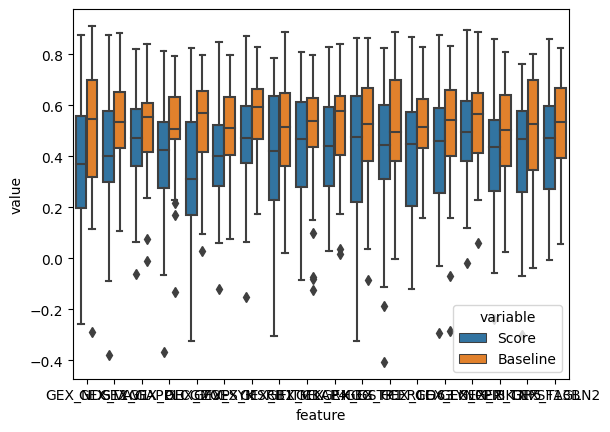

In [260]:
sns.boxplot(data = total.melt(id_vars=['feature','Fold'],value_vars=['Score','Baseline']), x = 'feature', y = 'value', hue = 'variable')

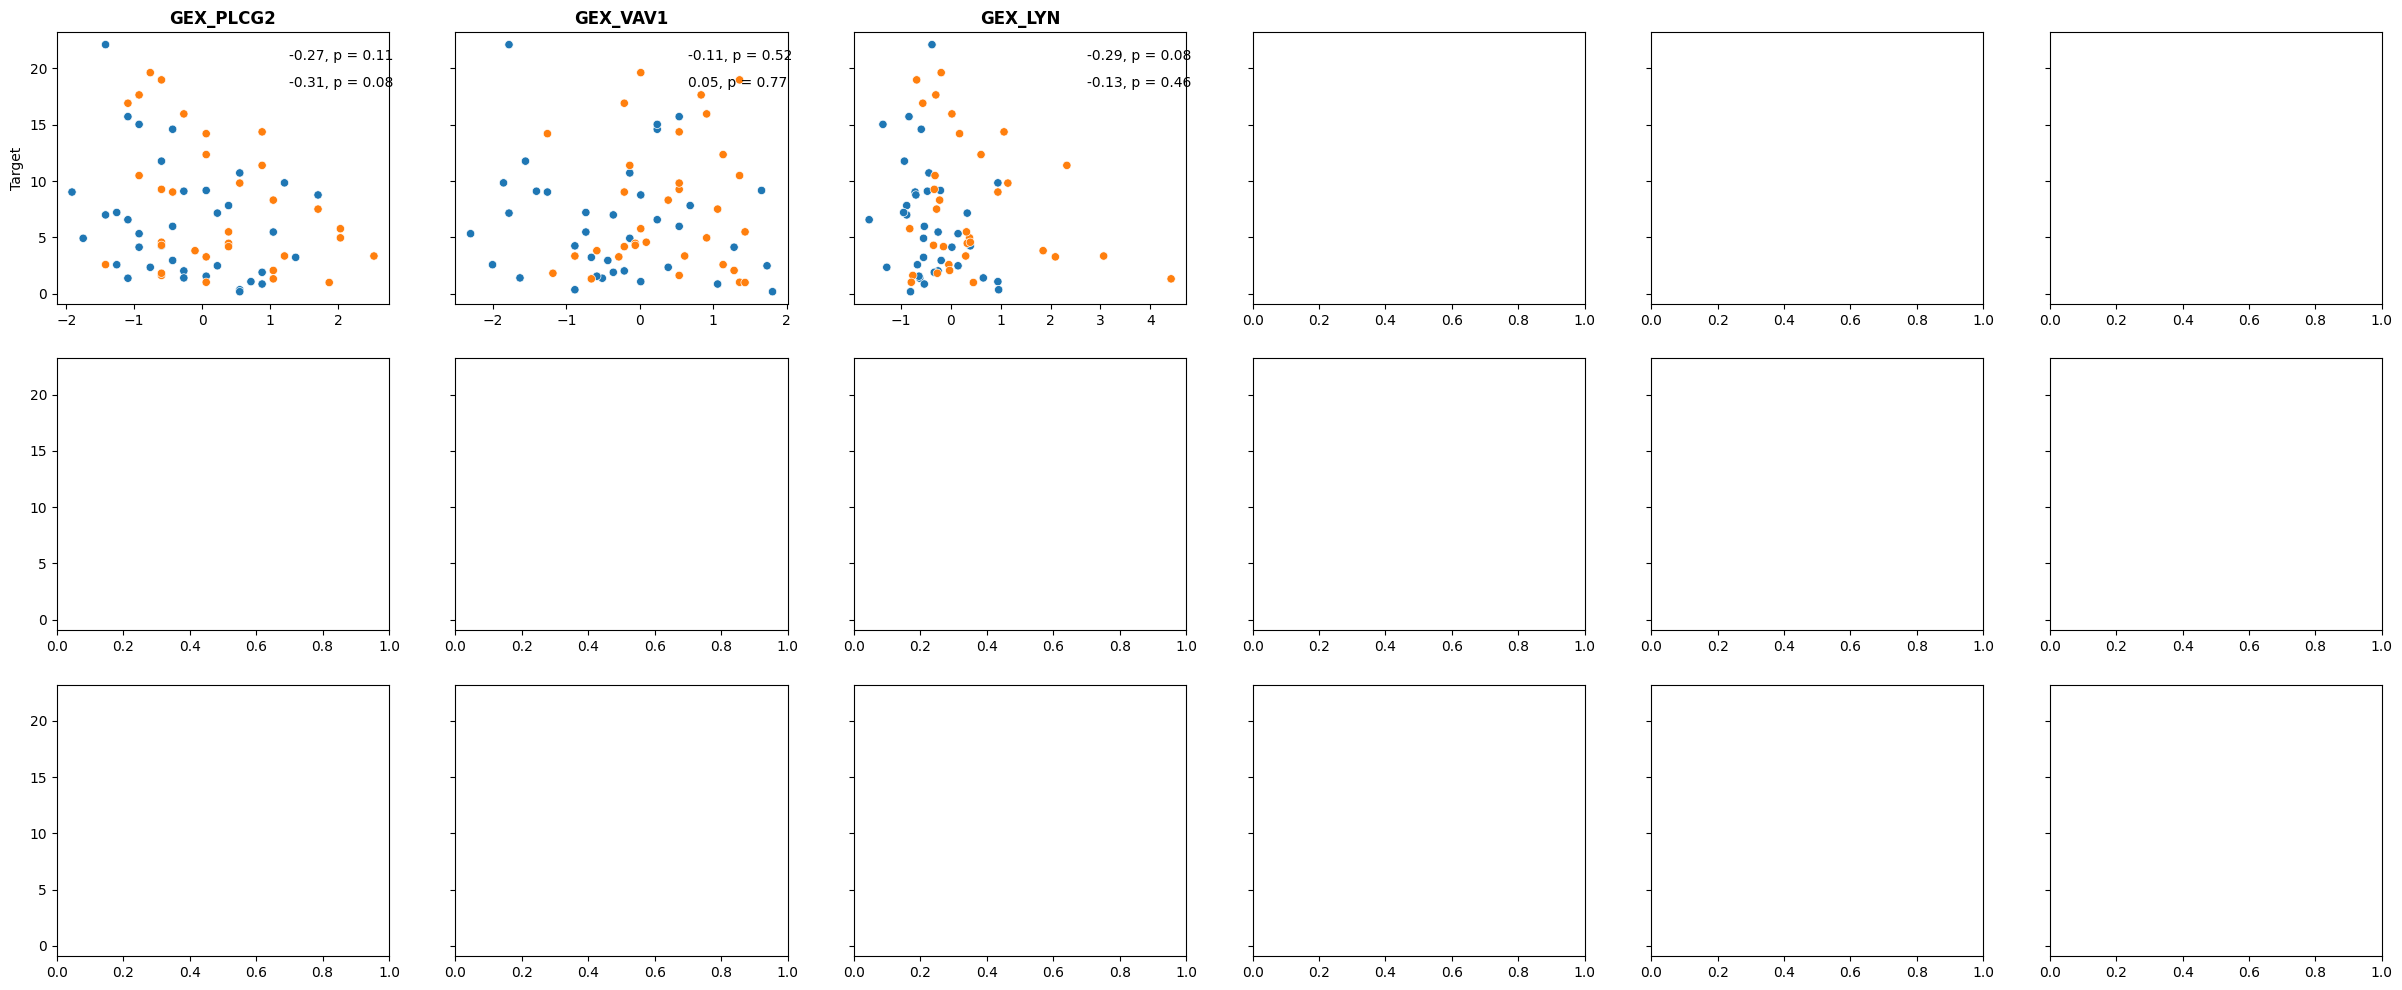

In [275]:
fig, ax = plt.subplots(3, 6, figsize=(30,12), sharey=True)

values = {}
for k,p in enumerate(features_sans_target):
  axis = ax[int(k/6)][k%6]
  sns.scatterplot(data = ds.data_normalized, x = p, y = 'Target', hue = 'dataset', ax = axis)
  axis.set_title(p, fontweight='bold')
  axis.set_xlabel('')
  d2020 = ds.data_normalized[ds.data_normalized['dataset']=='2020_dataset']
  val2020, pval2020 = spearmanr(d2020[p],d2020['Target'])
  xlim = axis.get_xlim()
  ylim = axis.get_ylim()
  axis.text(x=xlim[1]-0.3*(xlim[1]-xlim[0]), y=ylim[1]-0.1*(ylim[1]-ylim[0]),s= f'{val2020:.2f}, p = {pval2020:.2f}')
  d2021 = ds.data_normalized[ds.data_normalized['dataset']=='2021_dataset']
  val2021, pval2021 = spearmanr(d2021[p],d2021['Target'])
  xlim = axis.get_xlim()
  ylim = axis.get_ylim()
  values[p] = max([val2020, val2021])/min([val2020, val2021])
  axis.text(x=xlim[1]-0.3*(xlim[1]-xlim[0]), y=ylim[1]-0.2*(ylim[1]-ylim[0]),s= f'{val2021:.2f}, p = {pval2021:.2f}')
  axis.get_legend().remove()

In [ ]:
from sklearn.linear_model import LogisticRegression
hyperparam_search = {'alpha':[.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]}
vals = HyperparamSearch()
vals_out = vals.run_search(params = hyperparam_search, cv_func = regular_ol_cv, cv_args = {'data':ds.data_normalized, 'features': features_sans_target+['age','Titre_IgG_PT'], 'target':'Target', 'n_splits':5, 'score_function':corr_coeff_report, 'model_class': Lasso})

In [178]:
scores = pd.concat([x[0].assign(params = p) for p,x in enumerate(vals_out[0])])
scores['regularization'] = scores['params'].map(lambda x:vals_out[1][x]['alpha'])

In [ ]:
scores_flat = scores.melt(id_vars=['regularization'],value_vars=['Score','Baseline'])
ax = sns.boxplot(data = scores_flat, x = 'regularization', y = 'value', hue = 'variable')

In [ ]:
## Adapted from: https://alexmiller.phd/posts/linear-model-custom-loss-function-regularization-python/
##I added a second regularization, which is the "unreliabilities".
##This is intended to minimize coefficients for features that had
##conflicting correlation coefficients between batches.
##If no unreliabilities are supplied, that part of the loss
##disappears.

class CustomRidge:
    """
    Linear model: Y = XB, fit by minimizing the provided loss_function
    with L2 regularization
    """
    def __init__(self, loss_function=corr_coeff,
                 X=None, Y=None, sample_weights=None, beta_init=None,
                 regularization=0.000012, unreliabilities=None, method='nelder-mead'):
        self.regularization = regularization
        self.beta = None
        self.loss_function = loss_function
        self.sample_weights = sample_weights
        self.beta_init = beta_init
        self.unreliabilities = unreliabilities


    def predict(self, X):
        prediction = np.matmul(X, self.beta[:self.X.shape[1]])
        return(prediction)

    def model_error(self):
        error = self.loss_function(
            self.predict(self.X), self.Y
        )
        return(error)

    def l2_regularized_loss(self, beta):
        self.beta = beta
        print(self.beta)
        return(self.model_error() + \
               sum(self.regularization*np.array(self.beta[:self.X.shape[1]])**2)+
               sum(self.beta[:self.X.shape[1]]*self.beta[self.X.shape[1]:]))

    def fit(self, X, Y, maxiter=250):
        self.X = X
        self.Y = Y
        if type(self.unreliabilities) == type(None):
              self.unreliabilities = np.zeros(self.X.shape[1])
        if type(self.beta_init)==type(None):
            # set beta_init = 1 for every feature
            self.beta_init = np.hstack([np.array([1]*self.X.shape[1]),self.unreliabilities])
        else:
          self.beta_init = np.hstack([self.beta_init, self.unreliabilities])
          #  self.beta_init = np.reshape(np.stack([np.array([1]*self.X.shape[1]),self.unreliabilities], axis = 1), (2, self.X.shape[1], 2))

        if self.beta!=None and all(self.beta_init == self.beta):
            print("Model already fit once; continuing fit with more iterations.")
        print(self.beta_init)
        res = minimize(self.l2_regularized_loss, self.beta_init,
                       method='nelder-mead', options={'maxiter': 500})
        self.beta = res.x
        self.beta_init = self.beta
        self.coef_ = self.beta[:self.X.shape[1]]
        return self